#  **Lab 03: Implementing a Manual Quantized CNN with Look-Up Table (LUT)-Based Multiplication**

## 🔍 **Introduction**
In this lab, we will explore how to implement a **manual Convolutional Neural Network (CNN)** from scratch and replace its built-in multiplication operations with a **Look-Up Table (LUT)-based multiplication** mechanism.  

In typical CNN implementations, each convolution or dense layer performs thousands of multiplications between input activations and weights.  
When implementing **approximate multipliers**, repeatedly calling a custom function for each multiplication would be very slow.  
A much more efficient approach is to use a **Look-Up Table (LUT)** that stores the precomputed results of all possible multiplication pairs.  
Then, during inference, the model can simply read results from the table instead of performing direct arithmetic — a concept that significantly reduces computation time.

In this lab, to simplify the concept and keep the focus on the **LUT mechanism itself**, we will **use the LUT of an exact multiplier** (i.e., the results are mathematically correct).  
This allows you to understand how LUT-based computation works before moving to **approximate multipliers** in your homework.

---

## 🎯 **Objectives**
By the end of this lab, you will be able to:

1. **Implement** a manual 2D convolution function using LUT-based (exact) multiplication.  
2. **Modify** dense (fully connected) layers to use LUT-based multiplication as well.  
3. **Construct** a quantized *LeNet5-Inspired CNN* entirely from scratch using your custom convolution and dense functions.  
4. **Evaluate** the CNN’s performance and accuracy when all multiplications are replaced with LUT lookups.

---

> 🧠 **Key Concept:**  
> Instead of computing `a × b` directly, we use a **Look-Up Table** to fetch the result of that multiplication.  
> This approach forms the foundation for implementing **approximate arithmetic**, which you will explore in your homework.


## 🧩 **Step 1: Import Required Libraries**

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.models import load_model
import numpy as np
import matplotlib.pyplot as plt
import time
from tqdm import tqdm

## 🧩 **Step 2: Load the MNIST Dataset**

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


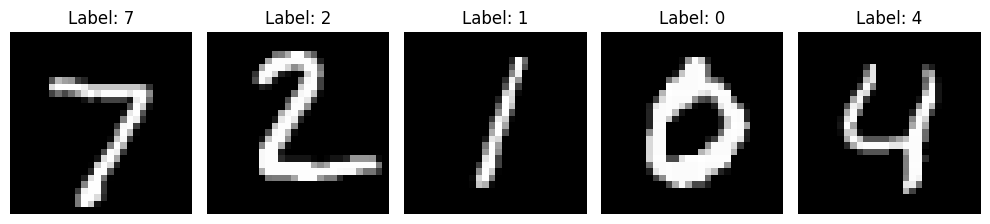

Training data shape: (60000, 28, 28, 1) (60000,)
Test data shape: (10000, 28, 28, 1) (10000,)


In [2]:
# -------------------------
# 1) Data: load + preprocess
# -------------------------
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# MNIST is 28x28 grayscale.
x_train = x_train.astype("uint8")
x_test  = x_test.astype("uint8")
x_train = x_train.reshape(-1, 28, 28, 1)
x_test  = x_test.reshape(-1, 28, 28, 1)

x_test_fp = x_test

#To visualize three test images from the testing set along with their corresponding labels, you can use the following code:
# Define the number of images to display
num_images = 5

# Create subplots for each image
plt.figure(figsize=(10, 3))
for i in range(num_images):
    plt.subplot(1, num_images, i + 1)
    plt.imshow(x_test[i], cmap='gray')
    plt.title(f"Label: {y_test[i]}")
    plt.axis('off')  # Hide the axis

plt.tight_layout()
plt.show()

# Check the shape of the data
print("Training data shape:", x_train.shape, y_train.shape)
print("Test data shape:", x_test.shape, y_test.shape)


## 🧩 **Step 3: Applying 8-bit Quantization to the MNIST Dataset**

In [3]:
# 1. Load MNIST dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# 2️. Convert to float32 for safe division
x_test = tf.cast(x_test, tf.float32)

# 3️. Normalize pixel values from [0, 255] → [0, 1]
x_test = x_test / 255.0

# 4️. Scale normalized values from [0, 1] → [0, 127]
x_test = x_test * 127.0

# 5️. Round to nearest integer
x_test = tf.round(x_test)

# 6️. Clip to make sure everything is within [0, 127]
x_test = tf.clip_by_value(x_test, 0.0, 127.0)

# 7. Reshape to (num_samples, 28, 28, 1)
x_test = tf.reshape(x_test, (-1, 28, 28, 1))


## 🧩 **Step 4: Load the Pre-trained LeNet-5 Inspired Model with Quantization**

In this step, we will load a **pre-trained and quantized LeNet-5-Inspired model**.  
This model has already been trained on the MNIST dataset to recognize handwritten digits and is designed to operate using **quantized weights and activations**.  
By using this pre-trained network, we can focus on understanding **how inference works** and how to integrate **LUT-based arithmetic**.

---

### 🧠 **What is Quantization?**

Quantization is the process of converting the **32-bit floating-point** values used in neural networks (for weights, biases, and activations) into **lower-precision integer values** — often 8-bit integers. This helps to make the network smaller, faster, and more efficient for deployment on edge devices or hardware accelerators.

---

### ⚖️ **Advantages and Trade-offs of Quantization**

#### ✅ *Advantages:*
- **Reduced Model Size:** Lower-bit weights take up less memory, which is crucial for embedded devices.  
- **Faster Inference:** Integer arithmetic is much faster than floating-point arithmetic, enabling near real-time performance.  
- **Lower Power Usage:** Fewer computational resources mean reduced power consumption — ideal for battery-powered systems.

#### ⚠️ *Potential Drawbacks:*
- **Slight Accuracy Loss:** Converting from float to int can introduce rounding errors.  
- **Limited Precision:** Very small weight updates or activation variations may be lost due to the reduced numerical range.

---
> We will later apply our **LUT-based multiplications** to this quantized model to simulate integer arithmetic behavior.


In [4]:
# Load your trained FP32 model
quantized_model = load_model("my_org_model_top4_quant.h5", compile=False)
quantized_model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)               │ (None, 28, 28, 64)     │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_8 (Activation)       │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 28, 28, 32)     │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_9 (Activation)       │ (None, 28, 28, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 28, 28, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 28, 28, 16)     │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_10 (Activation)      │ (None, 28, 28, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 26, 26, 8)      │         1,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_11 (Activation)      │ (None, 26, 26, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 26, 26, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 24, 24, 4)      │           292 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_12 (Activation)      │ (None, 24, 24, 4)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 24, 24, 4)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_13 (Activation)      │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_14 (Activation)      │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 10)             │           650 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_15 (Activation)      │ (None, 10)             │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 308,134 (1.18 MB)

 Trainable params: 308,134 (1.18 MB)

 Non-trainable params: 0 (0.00 B)

## 🧩 **Step 5: Overview and Analysis of Our CNN Model Architecture**

In this step, we will explore the structure of our **custom CNN model**, which is inspired by the classic **LeNet-5 architecture** — one of the first successful convolutional neural networks for image classification. This model is designed to recognize handwritten digits (0–9) from the MNIST dataset.  
We will also retrieve and examine the **weights** and **biases** of each layer to better understand how the model processes input data and learns visual patterns.

---

### 🏗️ **Model Structure**

Our CNN consists of three main components:

#### 🔹 **Convolutional Layers**
- The model begins with **five convolutional layers**.  
  Each layer applies a set of **filters (kernels)** that slide across the input image to detect specific local patterns such as edges, corners, and textures.  
- After each convolution, an **activation function (ReLU)** introduces non-linearity, allowing the network to learn more complex representations of the data.

#### 🔹 **Flattening Layer**
- Once the convolutional feature extraction is complete, the resulting 2D feature maps are **flattened** into a 1D array.  
  This operation prepares the extracted features for the **fully connected layers**, which handle the final classification.

#### 🔹 **Dense (Fully Connected) Layers**
- After flattening, the features are passed through **three dense layers**.  
  The first two dense layers are followed by activation functions that help the network learn higher-level feature combinations.  
  The final dense layer outputs **10 values**, each representing the probability that the input image belongs to one of the 10 digit classes (0–9).

---



In [5]:
# Get model weights and print model summary
model_weights = quantized_model.get_weights()

print("-"*40)
print("Convolution Layers:")
print("-"*40)
for layer in quantized_model.layers:
    if 'conv' in layer.name:  # This filters only convolutional layers
        print(f"Layer: Conv2D")

        # Get the weights and biases of the layer
        filters, biases = layer.get_weights()

        print(f"  Filters: shape = {filters.shape}")
        print(f"  Biases: shape = {biases.shape}")
i =0
print("-"*40)
print("Dense Layers (fully-connected Layers):")
print("-"*40)
for layer in quantized_model.layers:
    if 'dense' in layer.name:  # This filters only dense layers
        i += 1
        print(f"Dense_Layer {i} has {layer.units} neurons")

----------------------------------------
Convolution Layers:
----------------------------------------
Layer: Conv2D
  Filters: shape = (1, 1, 1, 64)
  Biases: shape = (64,)
Layer: Conv2D
  Filters: shape = (1, 1, 64, 32)
  Biases: shape = (32,)
Layer: Conv2D
  Filters: shape = (1, 1, 32, 16)
  Biases: shape = (16,)
Layer: Conv2D
  Filters: shape = (3, 3, 16, 8)
  Biases: shape = (8,)
Layer: Conv2D
  Filters: shape = (3, 3, 8, 4)
  Biases: shape = (4,)
----------------------------------------
Dense Layers (fully-connected Layers):
----------------------------------------
Dense_Layer 1 has 128 neurons
Dense_Layer 2 has 64 neurons
Dense_Layer 3 has 10 neurons


## 🧩 **Step 6: Creating a Look-Up Table (LUT) for Multiplication**

In this step, we will construct a **Look-Up Table (LUT)** that replaces traditional multiplication operations with **table lookups**.  
Instead of performing arithmetic calculations during convolution or dense operations, our model will **retrieve precomputed multiplication results** from the LUT.

Since our CNN uses **8-bit signed integers** for weights and activations, the LUT must cover all possible combinations of 8-bit signed values — from **-128 to +127**.

---

### 🔹 **Part 1: Building the LUT for Signed 8-Bit Multiplication**

#### ⚙️ **LUT Range**
The LUT needs to store results for every possible pair of signed 8-bit integers.

This creates a **256 × 256 table**, where each entry at position `(i, j)` represents the product of two integers `a × b`.

#### 💾 **Storage Concept**
- Each LUT entry corresponds to a **unique pair** of integers.  
- Once built, the LUT allows fast access — for example:
  ```python
`a × b` = `LUT[a + 128][b + 128]`

#### Why use `+128` for LUT indexing?
The `+128` offset ensures that signed integers in the range **[-128, 127]** map to valid LUT indices **[0, 255]**.  
Example: `-128 → 0`, `0 → 128`, `127 → 255`.

---

### 🔹 **Part 2: Implementing the Manual Element-Wise Multiplication Function**

Next, we’ll define a **custom element-wise multiplication function** that uses our LUT.  
This function will handle **2-dimensional element-wise multiplication** of two matrices with the same size — a common operation in **2D convolution** layers.


In [6]:
LUT = np.zeros((256,256),dtype=np.int32)
for i in range(-128,128):
    for j in range(-128,128):
        LUT[i +128,j+128]= i * j

In [7]:
def manual_elementwise_multiplication(a, b):
    """
    Custom element-wise multiplication function.
    Multiplies elements of a and b using pre-computed arrays based on type t.
    """
    a = np.array(a)
    b = np.array(b)
    a_shape = np.shape(a)
    b = np.reshape(b, a_shape)
    result = np.zeros(a_shape)

    for i in range(a_shape[0]):
        for j in range(a_shape[1]):
            result[i, j] = LUT[int(a[i, j]) + 128, int(b[i, j]) + 128]

    return result

## 🧩 **Step 7: Implementing a Manual 1-Channel 2D Convolution Function with LUT-Based Multiplication**

In this step, we implement a **custom 1-channel 2D convolution function** that uses the LUT for all multiplications.  
This function performs element-wise multiplications using the LUT instead of standard arithmetic.

---

### ⚙️ **Convolution Overview**

A **2D convolution** slides a filter (kernel) across the input image.  
At each position, it multiplies the kernel elements with the corresponding input patch and sums the results to form one output value, representing a detected feature.

---

### 🧠 **Key Components**

- **Sliding Window:**  
  The function extracts a patch of the input that matches the filter size for each position.

- **LUT-Based Multiplication:**  
  Each element-wise multiplication between the input patch and the filter is replaced by a **lookup** from the LUT.

- **Summation:**  
  All lookup results are summed to produce the final value for that output position in the feature map.


In [8]:
def manual_convolution(image, kernel):
    """
    manual 2D convolution using manual_elementwise_multiplication function.
    """
    # Determine the dimensions of image and kernel
    image_height, image_width = image.shape
    kernel_height, kernel_width = kernel.shape

    # Determine the output dimensions based on the dimensions of the input image and kernel
    output_height = image_height - kernel_height + 1
    output_width = image_width - kernel_width + 1

    # Initialize the output image by zero
    output = np.zeros((output_height, output_width))

    # Perform convolution
    for i in range(output_height):
        for j in range(output_width):
            # Element-wise multiplication of the kernel and the corresponding image region
            region = image[i:i+kernel_height, j:j+kernel_width]
            output[i, j] = np.sum(manual_elementwise_multiplication(region , kernel))

    return output

## 🧩 **Step 8: Implementing the Complete 2D Convolution Operation**

Now that we have built the LUT-based 1-channel convolution function,  
we can extend it to perform a **full 2D convolution** that supports multiple input channels and multiple filters (kernels), just like real CNN layers.

---

### ⚙️ **Understanding Full 2D Convolution**

In a CNN, the convolution operation is not limited to a single channel or a single kernel.  
Instead, we can have:
- **Multiple input channels** (e.g., from color channels or previous feature maps).
- **Multiple kernels (filters)**, where each kernel produces one output feature map.

Each kernel contains a separate **2D filter for each input channel**.  
During convolution, the process works as follows:

1. For a given kernel:
   - Each input channel is convolved with its corresponding kernel slice using the **1-channel LUT-based convolution**.
   - The results from all channels are **summed** element-wise to produce one **output feature map**.

2. This process is **repeated for all kernels**, meaning:
   - Each kernel produces one output feature map.
   - If there are multiple kernels, their results are **stacked** along the channel dimension, forming the final multi-channel output.

---

### 🔁 **Summary of the Process**
1. Loop over each **kernel** (filter).  
2. For each kernel:
   - Loop over all **input channels**.  
   - Perform the **LUT-based convolution** between the input channel and the corresponding kernel slice.  
   - **Sum** all the resulting feature maps across channels.  
3. Stack all kernel outputs to form the final multi-channel output.

---

> 💡 **Key Idea:**  
> A full 2D convolution is essentially a combination of many **1-channel convolutions**,  
> where results are **summed across channels** and **repeated across kernels** to extract rich features from the input.


In [10]:
def convolution_layer(input_feature_map, kernel, bias):

    input_shape = input_feature_map.shape # [input_height, output_height, channels]
    kernel_shape = kernel.shape # [kernel_height, kernel_weight, in_channels, out_channels]

    output_height = input_shape[0] - kernel_shape[0] + 1
    output_width = input_shape[1] - kernel_shape[1] + 1
    output_channels = kernel_shape[3]

    output = np.zeros([output_height, output_width, output_channels])

    for i in range(output_channels):
        for j in range(kernel_shape[2]):
            output[:, :, i] = output[:, :, i] + manual_convolution( input_feature_map[ :, :,j] , kernel[ :, :, j, i] )
        output[:, :, i] = output[:, :, i] + bias[i]

    return output

## 🧩 **Step 9: Implementing a Manual Dense (Fully Connected) Layer**

In this step, we implement a **manual dense layer** that performs matrix multiplication using our **LUT-based multiplication** functions.

---

### ⚙️ **How It Works**

1. **`manual_elementwise_1D_multiplication(a, b)`**  
   - Performs element-wise multiplication between two 1D vectors using the **LUT** instead of the `*` operator.  
   - Each pair `(a[i], b[i])` is multiplied by retrieving its result from the LUT.

2. **`manual_matrix_multiplication(a, b)`**  
   - Performs matrix multiplication manually using the above element-wise function.  
   - For each output position `(i, j)`, it multiplies the `i`-th row of `a` and the `j`-th column of `b` element-wise and sums the results.

3. **`dense_layer(input_vector, weights, bias)`**  
   - Computes the layer output by multiplying the input vector with the weight matrix using the manual matrix multiplication function, then adds the bias term.

---

### 🧠 **Summary**
This dense layer replaces standard NumPy or TensorFlow multiplications with **LUT-based arithmetic**, ensuring that every multiply operation in the network is handled through precomputed LUT lookups — maintaining consistency with our manual CNN design.


In [11]:
def manual_elementwise_1D_multiplication(a, b):
    """
    Custom element-wise multiplication function.
    Multiplies elements of a and b using pre-computed arrays based on type t.
    """
    a = np.array(a)
    b = np.array(b)
    a_shape = np.shape(a)
    b = np.reshape(b, a_shape)
    result = np.zeros(a_shape)

    # Perform element-wise multiplication for 1D array using LUT multiplication
    for i in range(a_shape[0]):
        result[i] = LUT[int(a[i]) + 128, int(b[i]) + 128]

    return result

###########################################################################################################

def manual_matrix_multiplication(a, b):
    """
    Custom matrix multiplication using custom_elementwise_multiplication function.
    """
    a = np.array(a)
    b = np.array(b)
    a_shape = np.shape(a)
    b_shape = np.shape(b)
    result = np.zeros([a_shape[0], b_shape[1]])

    # Perform matrix multiplication
    for i in range(a_shape[0]):
        for j in range(b_shape[1]):
            result[i, j] = np.sum(manual_elementwise_1D_multiplication(a[i, :], b[:, j]))
    return result

#############################################################################################################

def dense_layer(input_vector, weights, bias):

    output = manual_matrix_multiplication(input_vector, weights) + bias

    return output

## 🧩 **Step 10: Implementing the Manual Forward Pass**

In this step, we define a **manual forward pass** function that performs the entire inference process through our LUT-based CNN model.  
This function manually propagates one input image through all convolutional and dense layers, applying activation functions and quantization at each stage.

---

### ⚙️ **How It Works**

1. **Input Selection**  
   - The function takes an `image_index` and retrieves the corresponding image (`input_image`) from the dataset.

2. **Convolutional Layers**  
   - The image passes sequentially through **five convolutional layers**.  
   - Each layer performs:
     - Convolution using the **manual LUT-based convolution function**.  
     - **ReLU activation** (`np.maximum(0, x)`) to introduce non-linearity.  
     - **Dynamic normalization and quantization**, scaling outputs into the range **[-127, 127]** to maintain 8-bit precision.

3. **Flattening**  
   - The final feature map is reshaped into a 1D vector (`[1, 2304]`) to prepare it for the dense layers.

4. **Dense Layers**  
   - The flattened vector passes through **three dense (fully connected) layers**, each followed by:
     - **ReLU activation**  
     - **Normalization and quantization** to keep outputs within the 8-bit range.

5. **Output Prediction**  
   - The last dense layer produces a 10-element output vector (one for each digit class).  
   - The function selects the index of the maximum value using `np.argmax(x)`, representing the predicted digit.

---

### 🧠 **Summary**

This manual forward pass simulates a complete CNN inference pipeline using:
- **LUT-based multiplications** in all convolution and dense operations,  
- **Manual ReLU activations**,  
- **Dynamic quantization** after each layer.

By doing so, it reproduces the behavior of a quantized CNN entirely through low-level operations — providing a clear, step-by-step view of how each layer transforms the input into a final classification.


In [12]:
def manual_forward_pass(image_index):
    """
    Custom function to perform forward pass through the modified model.
    """
    # Perform a series of convolutions and activations
    input_image = input_features[image_index]


    x = convolution_layer(input_image, model_weights[0], model_weights[1])
    x = np.maximum(0, x) # RelU
    x = x / np.max(np.abs(x))
    x = np.round(x * 127.0)
    x = np.clip(x, -127.0, 127.0)


    x = convolution_layer(x, model_weights[2], model_weights[3])
    x = np.maximum(0, x) # RelU
    x = x / np.max(np.abs(x))
    x = np.round(x * 127.0)
    x = np.clip(x, -127.0, 127.0)


    x = convolution_layer(x, model_weights[4], model_weights[5])
    x = np.maximum(0, x) # RelU
    x = x / np.max(np.abs(x))
    x = np.round(x * 127.0)
    x = np.clip(x, -127.0, 127.0)


    x = convolution_layer(x, model_weights[6], model_weights[7])
    x = np.maximum(0, x) # RelU
    x = x / np.max(np.abs(x))
    x = np.round(x * 127.0)
    x = np.clip(x, -127.0, 127.0)


    x = convolution_layer(x, model_weights[8], model_weights[9])
    x = np.maximum(0, x) # RelU
    x = x / np.max(np.abs(x))
    x = np.round(x * 127.0)
    x = np.clip(x, -127.0, 127.0)


    x = np.reshape(x, [1, 2304])


    x = dense_layer(x, model_weights[10], model_weights[11])
    x = np.maximum(0, x) # RelU
    x = x / np.max(np.abs(x))
    x = np.round(x * 127.0)
    x = np.clip(x, -127.0, 127.0)


    x = dense_layer(x, model_weights[12], model_weights[13])
    x = np.maximum(0, x) # RelU
    x = x / np.max(np.abs(x))
    x = np.round(x * 127.0)
    x = np.clip(x, -127.0, 127.0)


    x = dense_layer(x, model_weights[14], model_weights[15])
    x = np.maximum(0, x) # RelU
    x = x / np.max(np.abs(x))
    x = np.round(x * 127.0)
    x = np.clip(x, -127.0, 127.0)

    detected_class = np.argmax(x)

    return detected_class

## 🧩 **Step 11: Evaluating Inference Performance and Accuracy**

In this final step, we evaluate the **inference speed and accuracy** of our manually implemented CNN that uses LUT-based multiplications.



In [13]:
# use 1000 test image from mnist dataset
batch_size = 1000
input_features = np.array(x_test[:batch_size], dtype=np.float32)

start_time = time.time()
nb_imgs = 10

results = []
for image_index in tqdm(range(nb_imgs)):
    results.append(int(manual_forward_pass(image_index)))

elapsed_time = time.time() - start_time
print('Execution time:', elapsed_time, 'seconds')

accuracy = np.sum(results == y_test[:len(results)]) / len(results)
print(f"Accuracy with multiplier: {accuracy}")

100%|██████████| 10/10 [03:58<00:00, 23.86s/it]

Execution time: 238.56162428855896 seconds
Accuracy with multiplier: 1.0
